# Deep Learning and Neural Networks
## MLPs and CNN in Keras

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.datasets import mnist, fashion_mnist
from keras import models, layers, utils
from keras.optimizers import Adam, RMSprop, SGD
from sklearn.model_selection import KFold
from functools import reduce

Using TensorFlow backend.


In [0]:
np.random.seed = 12
arr = np.arange(28)
np.random.shuffle(arr)

In [0]:
def learningCurve(data, model, epochs, m_type, op, figsize=(12,8)):
    if not os.path.exists('LC'):
        os.mkdir('LC')
    data = pd.DataFrame(data)
    data = data * 100
    data.plot(figsize=figsize)
    plt.grid(True)
    plt.gca().set_ylim(0, 100)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Percentage', fontsize=16)
    plt.xticks(range(epochs), range(epochs))
    plt.title('Learning curve - Model '+str(model)+' using '+str(op), fontsize=20)
    plt.savefig('LC/LC-'+str(m_type)+'Model-'+str(model)+'-'+str(op)+'.png')
    plt.show()

def permuteImagesCol(x, arr):
    for i in range( x.shape[0]):
        x[i] = x[i][:,arr]
    return x

def permuteImagesRow(x, arr):
    for i in range( x.shape[0]):
        x[i] = x[i][arr,:]
    return x
    
def box(MS, M_type, op):
    if not os.path.exists('Box'):
        os.mkdir('Box')
    fig = plt.figure(figsize=(12,8))
    plt.boxplot(MS.reshape(MS.shape[1],MS.shape[0]))
    plt.xticks(range(1, MS.shape[0]+1), range(MS.shape[0]))
    plt.xlabel('Models', fontsize=16)
    plt.ylabel('Accuracies', fontsize=16)
    plt.title(str(M_type)+' model Evaluation after 5-fold CV using '+str(op), fontsize=20)
    fig.savefig('Box/boxplot-'+str(M_type)+'-'+str(op)+'.png')
    plt.show()

In [0]:
class classifier():
    def __init__(self, data, arr, nc=10):
        (self.x_train, self.y_train), (self.x_test, self.y_test) = data.load_data()
        self.op_classes = nc
        self.batch_size = 128
        self.epochs = 10
        self.folds = 5
        self.shuffle = arr
    
    def scaleImages(self):
        ## Splitting data into validation, train, test sets while normalizing the values
        self.x_train = self.x_train.astype('float32')
        self.x_test = self.x_test.astype('float32')
        self.x_train = self.x_train/255
        self.x_test = self.x_test/255
    
    def hotEncode(self):
        ## One hot encoding of the labels
        self.y_train = utils.to_categorical(self.y_train, self.op_classes)
        self.y_test  = utils.to_categorical(self.y_test , self.op_classes)
        
    def preprocessing(self, resh = False):
        ## Reshaping the images
        if resh:
            self.x_train = self.x_train.reshape((self.x_train.shape[0], 28, 28, 1)) 
            self.x_test  = self.x_test.reshape( (self.x_test.shape[0] , 28, 28, 1))
        self.scaleImages()
        ## Obfuscating the data
        self.x_train = permuteImagesRow(self.x_train, self.shuffle)
        self.x_train = permuteImagesCol(self.x_train, self.shuffle)

        self.x_test = permuteImagesRow(self.x_test, self.shuffle)
        self.x_test = permuteImagesCol(self.x_test, self.shuffle)
        
        self.hotEncode()
        
    def classifierMLP(self, depth, width, activation, op, input_shape):        
        self.model = models.Sequential()
        self.model.add(layers.Flatten(input_shape=input_shape))
        for i in range(0, depth):
            self.model.add(layers.Dense(width[i], activation=activation[i]))
        self.model.add(layers.Dense(self.op_classes,activation='softmax'))
        self.model.compile(loss='categorical_crossentropy', optimizer=op(), metrics=['accuracy'])

    def classifierCNN(self, depth, width, activation, op, pool, dropout, kernel, input_shape=(28, 28, 1)):
        self.model = models.Sequential()
        self.model.add(layers.Conv2D(width[0], kernel_size=kernel[0], activation=activation[0],
                 input_shape=input_shape))
        if pool[0][0]:
            self.model.add(layers.MaxPooling2D(pool_size=pool[0][1]))
        if dropout[0][0]:
            self.model.add(layers.Dropout(dropout[0][1]))
        if depth>2:
          for i in range(1, depth-1):
              self.model.add(layers.Conv2D(width[i], kernel_size=kernel[i], activation=activation[i]))
              if pool[i][0]:
                  self.model.add(layers.MaxPooling2D(pool_size=pool[i][1]))
              if dropout[i][0]:
                  self.model.add(layers.Dropout(dropout[i][1]))
        self.model.add(layers.Flatten())
        self.model.add(layers.Dense(width[-1], activation=activation[-1]))
        self.model.add(layers.Dropout(dropout[-1][1]))
        self.model.add(layers.Dense(self.op_classes, activation='softmax'))

        self.model.compile(loss='categorical_crossentropy', optimizer=op(), metrics=['accuracy'])

    def modelEvaluation(self):
        scores, histories = list(), list()
        folds = KFold(self.folds, shuffle=True, random_state=1)
        for train_index, val_index in folds.split(self.x_train):
            x_train, y_train, x_val, y_val = self.x_train[train_index], self.y_train[train_index], self.x_train[val_index], self.y_train[val_index]
            history = self.model.fit(x_train, y_train, epochs=self.epochs, verbose=0,
                                batch_size=self.batch_size, validation_data=(x_val, y_val))
            acc = self.model.evaluate(self.x_test, self.y_test, verbose=0)
            scores.append(acc)
            histories.append(history.history)
        histories = reduce(lambda x, y: pd.DataFrame(x) + pd.DataFrame(y), histories)   
        mean_score = pd.DataFrame(scores).sum().to_numpy()/self.folds
        return mean_score, histories/self.folds, scores    
        
    def RunTest(self, model_type, widths, activation, optimizers, pool=[], dropout=[], kernel=[]):
        if model_type == 'MLP':
            self.preprocessing()
        if model_type == 'CNN':
          self.preprocessing(True)
        print('Data set size: ')
        print('\t', self.x_train.shape[0], 'train samples')
        print('\t',self.x_test.shape[0], 'test samples')
        model_count = 0
        for op in optimizers:
          model_scores = np.empty((len(widths), self.folds))
          if not os.path.exists('Models'):
              os.mkdir('Models')
          for i in range(len(widths)):
              print("\n")
              print("Model %d Summary: " %model_count)
              if model_type == 'MLP':
                  self.classifierMLP(depth=len(widths[i]), width=widths[i], activation=activation[i], op=op[0], input_shape=[28, 28])
              if model_type== 'CNN':
                  self.classifierCNN(depth=len(widths[i]), width=widths[i], activation=activation[i], op=op[0], pool=pool[i], dropout=dropout[i], kernel=kernel[i])
              self.model.summary()
              mean_score, histories, scores = self.modelEvaluation()
              model_scores[i] = pd.DataFrame(scores).iloc[:,1].to_numpy()
              print('Average 5-fold Test accuracy %.3f' % (mean_score[1] * 100))
              print('Average 5-fold Test loss %.3f' % (mean_score[0] * 100))
              
              learningCurve(histories, model_count, self.epochs, model_type, op[1])
              self.model.save('Models/Model-'+str(model_count)+'-D-'+str(len(widths[i]))+'-Score-'+str(round(mean_score[1],2))+str(op[1])+'.h5')
              model_count+=1
              
          box(model_scores, model_type, op[1])


### MLP using MNIST and fashion MNIST

In [0]:
widths = [[28, 56, 112]]
activation = [['relu', 'relu', 'relu']]
optimizers = [[Adam, 'Adam']]
model_type = 'MLP'

Data set size: 
	 60000 train samples
	 10000 test samples


Model 0 Summary: 
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 28)                21980     
_________________________________________________________________
dense_2 (Dense)              (None, 56)                1624      
_________________________________________________________________
dense_3 (Dense)              (None, 112)               6384      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1130      
Total params: 31,118
Trainable params: 31,118
Non-trainable params: 0
_________________________________________________________________
Average 5-fold Test accuracy 96.744
A

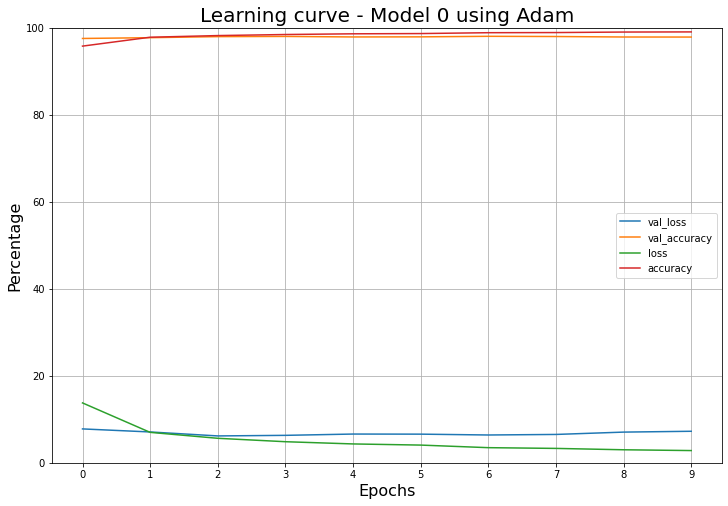

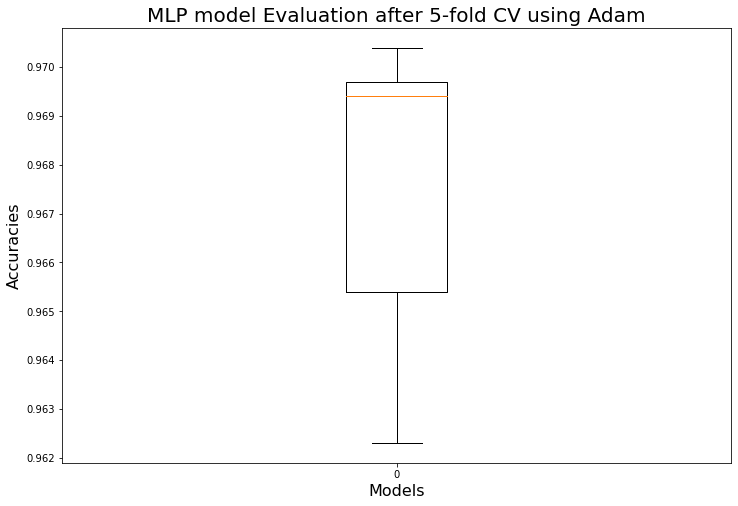

CPU times: user 1min 20s, sys: 10.6 s, total: 1min 31s
Wall time: 1min 12s


In [6]:
%%time
if not os.path.exists('MNIST_MLP'):
        os.mkdir('MNIST_MLP')
os.chdir('MNIST_MLP')
MNIST_MLP = classifier(mnist, arr)
MNIST_MLP.RunTest(model_type, widths, activation, optimizers)
os.chdir('../')

4423680/4422102 [==============================] - 0s 0us/step
Data set size: 
	 60000 train samples
	 10000 test samples


Model 0 Summary: 
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 28)                21980     
_________________________________________________________________
dense_6 (Dense)              (None, 56)                1624      
_________________________________________________________________
dense_7 (Dense)              (None, 112)               6384      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1130      
Total params: 31,118
Trainable params: 31,118
Non-trainable params: 0
________________________________________

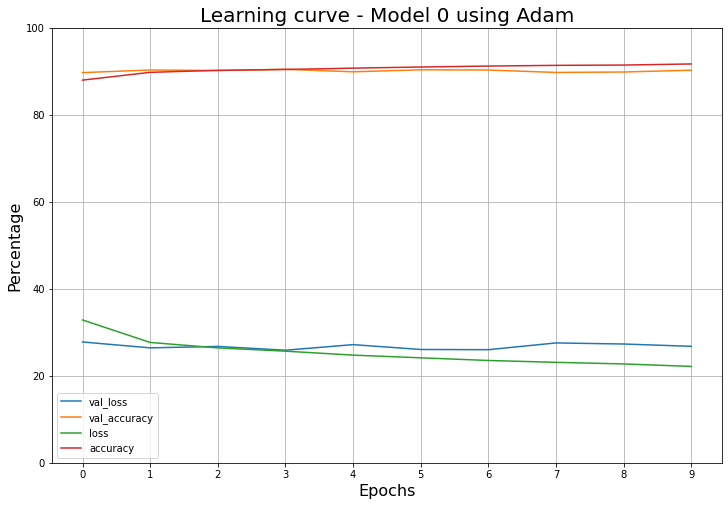

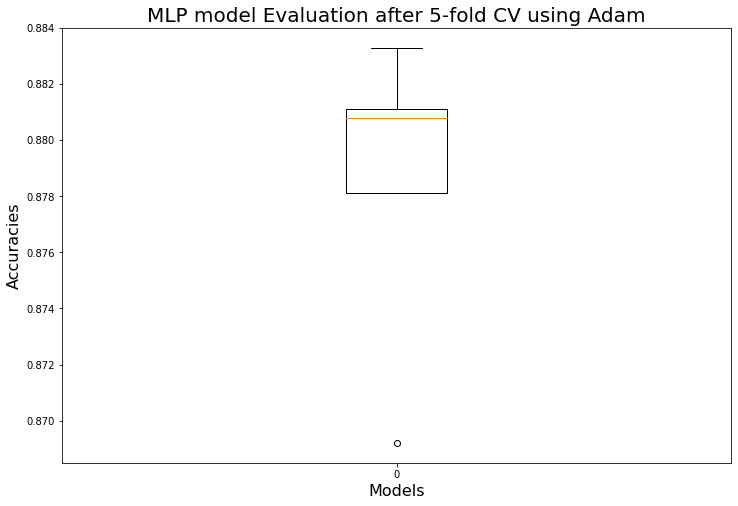

CPU times: user 1min 20s, sys: 11.5 s, total: 1min 31s
Wall time: 1min 12s


In [7]:
%%time
if not os.path.exists('F_MNIST_MLP'):
        os.mkdir('F_MNIST_MLP')
os.chdir('F_MNIST_MLP')
F_MNIST_MLP = classifier(fashion_mnist, arr)
F_MNIST_MLP.RunTest(model_type, widths, activation, optimizers)
os.chdir('../')

### CNN using MNIST and fashion MNIST

In [0]:
widths = [[28, 14, 100]]
kernel = [[(2,2), (2,2)]]
activation = [['relu', 'relu', 'relu']]
pool = [[ [False, (0,0)], [True, (2,2)]] ]
dropout = [[ [False, 0], [True, 0.2], [True, 0.2]]]
optimizers = [[Adam, 'Adam']]
model_type = 'CNN'

Data set size: 
	 60000 train samples
	 10000 test samples


Model 0 Summary: 
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 27, 27, 28)        140       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 14)        1582      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 14)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 14)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2366)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               236700    
_________________________________________

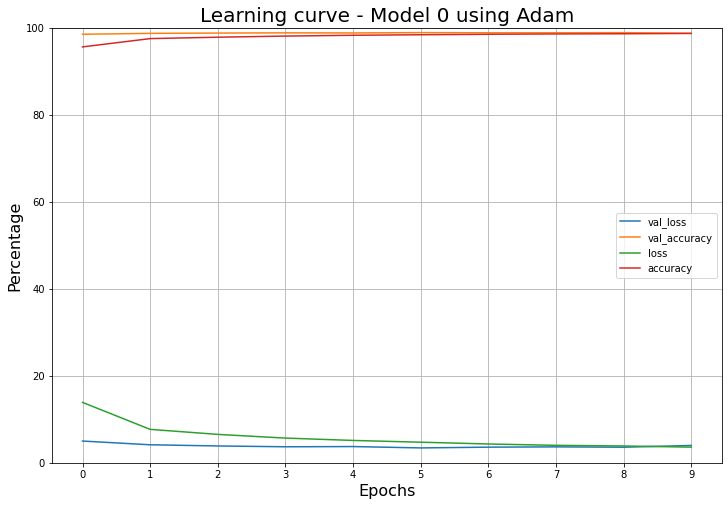

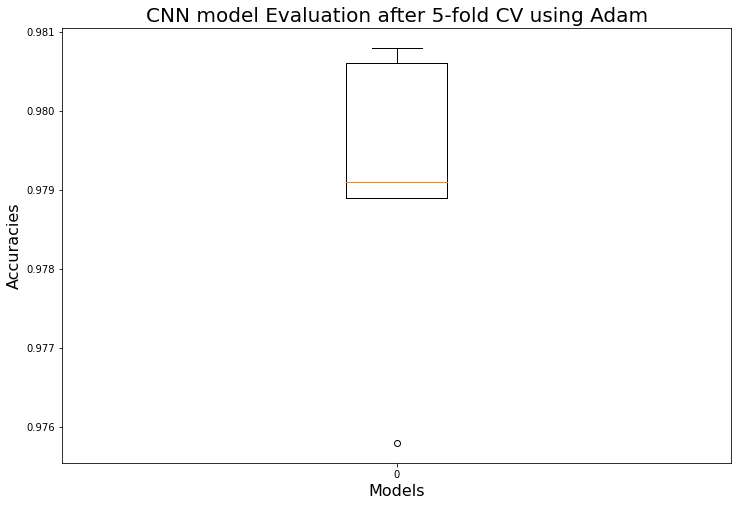

CPU times: user 1min 47s, sys: 16.6 s, total: 2min 4s
Wall time: 1min 52s


In [9]:
%%time
if not os.path.exists('MNIST_CNN'):
        os.mkdir('MNIST_CNN')
os.chdir('MNIST_CNN')
MNIST_CNN = classifier(mnist, arr)
MNIST_CNN.RunTest(model_type, widths, activation, optimizers, pool, dropout, kernel)
os.chdir('../')

Data set size: 
	 60000 train samples
	 10000 test samples


Model 0 Summary: 
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 27, 27, 28)        140       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 14)        1582      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 14)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 13, 13, 14)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2366)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               236700    
_________________________________________

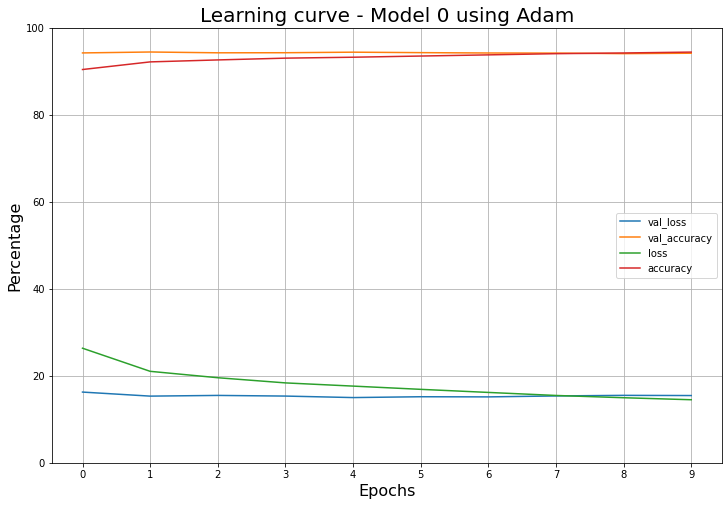

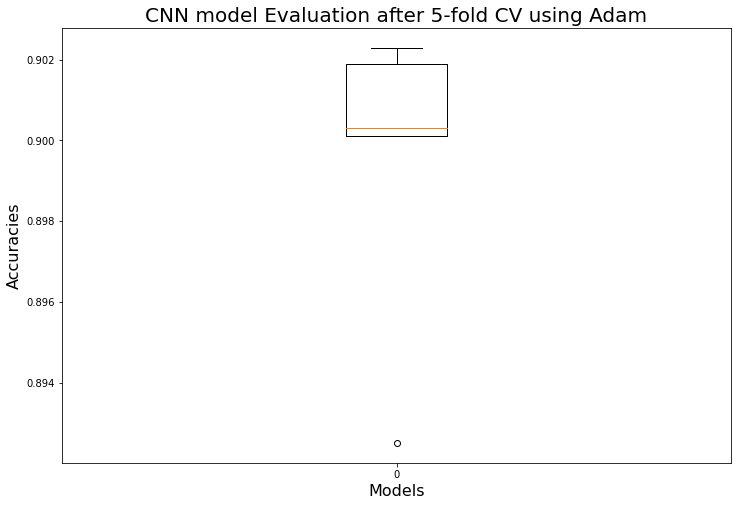

CPU times: user 1min 50s, sys: 16.8 s, total: 2min 6s
Wall time: 1min 47s


In [10]:
%%time
if not os.path.exists('F_MNIST_CNN'):
        os.mkdir('F_MNIST_CNN')
os.chdir('F_MNIST_CNN')
F_MNIST_CNN = classifier(fashion_mnist, arr)
F_MNIST_CNN.RunTest(model_type, widths, activation, optimizers, pool, dropout, kernel)
os.chdir('../')